# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use SFrames to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

## Fire up GraphLab Create

Make sure you have the latest version of GraphLab Create. If you don't find the decision tree module, then you would need to upgrade GraphLab Create using

```
   pip install graphlab-create --upgrade
```

In [1]:
import sframe
# graphlab.canvas.set_target('ipynb')

# Load LendingClub dataset

We will be using a dataset from the [LendingClub](https://www.lendingclub.com/). A parsed and cleaned form of the dataset is availiable [here](https://github.com/learnml/machine-learning-specialization-private). Make sure you **download the dataset** before running the following command.

In [3]:
loans = sframe.SFrame('lending-club-data.gl/')

## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [4]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

In [11]:
print len(loans[loans['safe_loans'] == 1])
print len(loans)

99457
122607


You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [12]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [13]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print "Number of safe loans  : %s" % len(safe_loans_raw)
print "Number of risky loans : %s" % len(risky_loans_raw)

Number of safe loans  : 99457
Number of risky loans : 23150


Now, write some code to compute below the percentage of safe and risky loans in the dataset and validate these numbers against what was given using `.show` earlier in the assignment:

In [15]:
print "Percentage of safe loans  :", 1.0 * len(safe_loans_raw) / len(loans)
print "Percentage of risky loans :", 1.0 * len(risky_loans_raw) / len(loans)

Percentage of safe loans  : 0.811185331996
Percentage of risky loans : 0.188814668004


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

In [16]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [17]:
print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split and specifying `seed=1` so everyone gets the same results.

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [20]:
categorical_variables = []
for feat_name, feat_type in zip(loans_data.column_names(), loans_data.column_types()):
    if feat_type == str:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

In [22]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Use decision tree to build a classifier

Now, let's use the built-in GraphLab Create decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.)  Our feature columns and target column have already been decided above. Use `validation_set=None` to get the same results as everyone else.

In [26]:
import sklearn, numpy

In [35]:
decision_tree_model = sklearn.tree.DecisionTreeClassifier(max_depth=6)
names = train_data.column_names()
train_features = [i for i in names if i != target]
decision_tree_model.fit(train_data[train_features].to_numpy(), train_data[target].to_numpy())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [58]:
simple_model = sklearn.tree.DecisionTreeClassifier(max_depth=2)
simple_model.fit(train_data[train_features].to_numpy(), train_data[target].to_numpy())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Visualizing a learned model

As noted in the [documentation](https://turi.com/products/create/docs/generated/graphlab.boosted_trees_classifier.create.html#graphlab.boosted_trees_classifier.create), typically the max depth of the tree is capped at 6. However, such a tree can be hard to visualize graphically.  Here, we instead learn a smaller model with **max depth of 2** to gain some intuition by visualizing the learned tree.

In [37]:
import graphviz

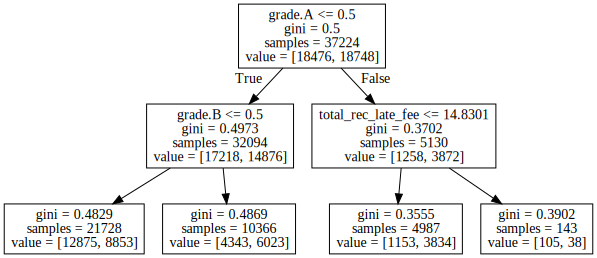

In [60]:
dot_data = sklearn.tree.export_graphviz(simple_model, out_file=None, feature_names=train_features) 
graph = graphviz.Source(dot_data) 
graph

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [44]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	short_emp	int
	emp_length_num	int
	dti	float
	last_delinq_none	int
	last_major_derog_none	int
	revol_util	float
	total_rec_late_fee	float
	safe_loans	int
	grade.A	int
	grade.B	int
	grade.C	int
	grade.D	int
	grade.E	int
	grade.F	int
	grade.G	int
	sub_grade.A1	int
	sub_grade.A2	int
	sub_grade.A3	int
	sub_grade.A4	int
	sub_grade.A5	int
	sub_grade.B1	int
	sub_grade.B2	int
	sub_grade.B3	int
	sub_grade.B4	int
	sub_grade.B5	int
	sub_grade.C1	int
	sub_grade.C2	int
	sub_grade.C3	int
	sub_grade.C4	int
	sub_grade.C5	int
	sub_grade.D1	int
	sub_grade.D2	int
	sub_grade.D3	int
	sub_grade.D4	int
	sub_grade.D5	int
	sub_grade.E1	int
	sub_grade.E2	int
	sub_grade.E3	int
	sub_grade.E4	int
	sub_grade.E5	int
	sub_grade.F1	int
	sub_grade.F2	int
	sub_grade.F3	int
	sub_grade.F4	int
	sub_grade.F5	int
	sub_grade.G1	int
	sub_grade.G2	int
	sub_grade.G3	int
	sub_grade.G4	int
	sub_grade.G5	int
	home_ownership.MORTGAGE	int
	home_ownership.OTHER	int
	home_ownership.OWN	int
	home_ownership.RENT	int
	purpose.car	int
	purpose.credit_card	int
	purpose.debt_consolidation	int
	purpose.home_improvement	int
	purpose.house	int
	purpose.major_purchase	int
	purpose.medical	int
	purpose.moving	int
	purpose.other	int
	purpose.small_business	int
	purpose.vacation	int
	purpose.wedding	int
	term. 36 months	int
	term. 60 months	int

Rows: 4

Data:
+-----------+----------------+-------+------------------+-----------------------+
| short_emp | emp_length_num |  dti  | last_delinq_none | last_major_derog_none |
+-----------+----------------+-------+------------------+-----------------------+
|     0     |       11       | 11.18 |        1         |           1           |
|     0     |       10       | 16.85 |        1         |           1           |
|     0     |       3        | 13.97 |        0         |           1           |
|     0     |       11       | 16.33 |        1         |           1           |
+-----------+----------------+-------+------------------+-----------------------+
+------------+--------------------+------------+---------+---------+---------+---------+
| revol_util | total_rec_late_fee | safe_loans | grade.A | grade.B | grade.C | grade.D |
+------------+--------------------+------------+---------+---------+---------+---------+
|    82.4    |        0.0         |     1      |    0    |    1    |    0    |    0    |
|    96.4    |        0.0         |     1      |    0    |    0    |    0    |    1    |
|    59.5    |        0.0         |     -1     |    0    |    0    |    0    |    1    |
|    62.1    |        0.0         |     -1     |    1    |    0    |    0    |    0    |
+------------+--------------------+------------+---------+---------+---------+---------+
+---------+---------+---------+--------------+--------------+--------------+--------------+
| grade.E | grade.F | grade.G | sub_grade.A1 | sub_grade.A2 | sub_grade.A3 | sub_grade.A4 |
+---------+---------+---------+--------------+--------------+--------------+--------------+
|    0    |    0    |    0    |      0       |      0       |      0       |      0       |
|    0    |    0    |    0    |      0       |      0       |      0       |      0       |
|    0    |    0    |    0    |      0       |      0       |      0       |      0       |
|    0    |    0    |    0    |      0       |      0       |      0       |      0       |
+---------+---------+---------+--------------+--------------+--------------+--------------+
+--------------+-----+
| sub_grade.A5 | ... |
+--------------+-----+
|      0       | ... |
|      0       | ... |
|      0       | ... |
|      1       | ... |
+--------------+-----+
[4 rows x 68 columns]

## Explore label predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [48]:
decision_tree_model.predict(sample_validation_data[train_features].to_numpy())

array([ 1, -1, -1,  1])

**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `decision_tree_model` get correct?

## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** Set `output_type='probability'` to make **probability** predictions using **decision_tree_model** on `sample_validation_data`:

In [51]:
print decision_tree_model.classes_
decision_tree_model.predict_proba(sample_validation_data[train_features].to_numpy())

[-1  1]


array([[ 0.34156543,  0.65843457],
       [ 0.53630646,  0.46369354],
       [ 0.64750958,  0.35249042],
       [ 0.20789474,  0.79210526]])

**Quiz Question:** Which loan has the highest probability of being classified as a **safe loan**?

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

### Tricky predictions!

Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

**Hint:** Set `output_type='probability'` to make **probability** predictions using **small_model** on `sample_validation_data`:

In [52]:
simple_model.predict_proba(sample_validation_data[train_features].to_numpy())

array([[ 0.41896585,  0.58103415],
       [ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661],
       [ 0.23120112,  0.76879888]])

**Quiz Question:** Notice that the probability preditions are the **exact same** for the 2nd and 3rd loans. Why would this happen?

## Visualize the prediction on a tree


Note that you should be able to look at the small tree, traverse it yourself, and visualize the prediction being made. Consider the following point in the **sample_validation_data**

In [53]:
sample_validation_data[1]

{'dti': 16.85,
 'emp_length_num': 10,
 'grade.A': 0,
 'grade.B': 0,
 'grade.C': 0,
 'grade.D': 1,
 'grade.E': 0,
 'grade.F': 0,
 'grade.G': 0,
 'home_ownership.MORTGAGE': 0,
 'home_ownership.OTHER': 0,
 'home_ownership.OWN': 0,
 'home_ownership.RENT': 1,
 'last_delinq_none': 1,
 'last_major_derog_none': 1,
 'purpose.car': 0,
 'purpose.credit_card': 0,
 'purpose.debt_consolidation': 1,
 'purpose.home_improvement': 0,
 'purpose.house': 0,
 'purpose.major_purchase': 0,
 'purpose.medical': 0,
 'purpose.moving': 0,
 'purpose.other': 0,
 'purpose.small_business': 0,
 'purpose.vacation': 0,
 'purpose.wedding': 0,
 'revol_util': 96.4,
 'safe_loans': 1,
 'short_emp': 0,
 'sub_grade.A1': 0,
 'sub_grade.A2': 0,
 'sub_grade.A3': 0,
 'sub_grade.A4': 0,
 'sub_grade.A5': 0,
 'sub_grade.B1': 0,
 'sub_grade.B2': 0,
 'sub_grade.B3': 0,
 'sub_grade.B4': 0,
 'sub_grade.B5': 0,
 'sub_grade.C1': 0,
 'sub_grade.C2': 0,
 'sub_grade.C3': 0,
 'sub_grade.C4': 0,
 'sub_grade.C5': 0,
 'sub_grade.D1': 1,
 'sub_grad

Let's visualize the small tree here to do the traversing for this data point.

**Note:** In the tree visualization above, the values at the leaf nodes are not class predictions but scores (a slightly advanced concept that is out of the scope of this course). You can read more about this [here](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf).  If the score is $\geq$ 0, the class +1 is predicted.  Otherwise, if the score < 0, we predict class -1.


**Quiz Question:** Based on the visualized tree, what prediction would you make for this data point?

Now, let's verify your prediction by examining the prediction made using GraphLab Create.  Use the `.predict` function on `small_model`.

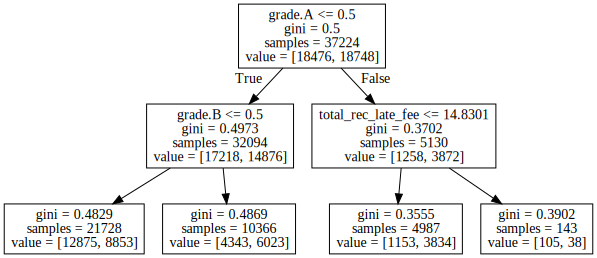

In [61]:
graph

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [64]:
print sklearn.metrics.accuracy_score(train_data[target].to_numpy(), simple_model.predict(train_data[train_features].to_numpy()))
print sklearn.metrics.accuracy_score(train_data[target].to_numpy(), decision_tree_model.predict(train_data[train_features].to_numpy()))

0.613502041694
0.640527616591


**Checkpoint:** You should see that the **small_model** performs worse than the **decision_tree_model** on the training data.


Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above.

In [65]:
print sklearn.metrics.accuracy_score(validation_data[target].to_numpy(), simple_model.predict(validation_data[train_features].to_numpy()))
print sklearn.metrics.accuracy_score(validation_data[target].to_numpy(), decision_tree_model.predict(validation_data[train_features].to_numpy()))

0.619345109866
0.636148211978


**Quiz Question:** What is the accuracy of `decision_tree_model` on the validation set, rounded to the nearest .01?

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [66]:
big_model = sklearn.tree.DecisionTreeClassifier(max_depth=10)
big_model.fit(train_data[train_features].to_numpy(), train_data[target].to_numpy())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now, let us evaluate **big_model** on the training set and validation set.

In [68]:
print sklearn.metrics.accuracy_score(train_data[target].to_numpy(), big_model.predict(train_data[train_features].to_numpy()))
print sklearn.metrics.accuracy_score(validation_data[target].to_numpy(), big_model.predict(validation_data[train_features].to_numpy()))

0.663845905867
0.626561826799


**Checkpoint:** We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

**Quiz Question:** How does the performance of **big_model** on the validation set compare to **decision_tree_model** on the validation set? Is this a sign of overfitting?

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [70]:
predictions = decision_tree_model.predict(validation_data[train_features].to_numpy())

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [79]:
fp = ((predictions - validation_data[target]) == 2).sum()

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [80]:
fn = ((predictions - validation_data[target]) == -2).sum()

**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [81]:
print 10000 * fn + 20000 * fp

50390000
